In [1]:
##readme : download and run jupyter notebook with input data files oncogenic_drivers_3B_C.txt and 
#all_somatic_drivers_3D.txt in data sub-directory

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
#oncogenic mutation status for cohort excluding hyper mutated cases
somatic_oncogenic_status = pd.read_csv("../data/oncogenic_drivers_3B_C.txt",
                                        sep = '\t')
print somatic_oncogenic_status.shape


(13648, 7)


In [4]:
#subset of patients with one or more drivers

penetrance_order = {'High':1, 'Moderate':2, 'Low':3, 'Uncertain':4}

somatic_oncogenic_status['penetrance_order'] = somatic_oncogenic_status['penetrance'].map(penetrance_order)
penetrance = 'High'
hi_pen = somatic_oncogenic_status[(somatic_oncogenic_status['penetrance'] == penetrance) ]
tumortypes_included = hi_pen['Proposed_level'].unique().tolist()

pts_hi_pen_het = hi_pen[hi_pen['bi-allelic']==0]['Patient_ID'].unique().tolist()
pts_hi_pen_biallelic = hi_pen[hi_pen['bi-allelic']==1]['Patient_ID'].unique().tolist()
lower_pen = somatic_oncogenic_status[somatic_oncogenic_status['penetrance_order'] > penetrance_order[penetrance]]
pts_lower_pen = lower_pen['Patient_ID'].unique().tolist()
    
gl_wt_type = somatic_oncogenic_status[(~(somatic_oncogenic_status['Patient_ID'].isin(pts_hi_pen_het))) &
                                      (~(somatic_oncogenic_status['Patient_ID'].isin(pts_hi_pen_biallelic))) &
                                          (~(somatic_oncogenic_status['Patient_ID'].isin(pts_lower_pen))) &
                                         (somatic_oncogenic_status['Proposed_level'].isin(tumortypes_included))]['Patient_ID'].unique().tolist()

In [5]:
somatic_oncogenic_status['gl_status'] = np.where(somatic_oncogenic_status['Patient_ID'].isin(pts_hi_pen_biallelic),
                                                 "biallelic", 
                                                 "wildtype")
somatic_oncogenic_status['gl_status'] = np.where(somatic_oncogenic_status['Patient_ID'].isin(pts_hi_pen_het),
                                                 "heterozygous", 
                                                 somatic_oncogenic_status['gl_status'])
somatic_oncogenic_status['gl_status'] = np.where(somatic_oncogenic_status['Patient_ID'].isin(pts_lower_pen),
                                                 "M/L/U", 
                                                 somatic_oncogenic_status['gl_status'])
                                                 
                                                 
summary_counts = pd.DataFrame({
        'tumortype_count' : 
        somatic_oncogenic_status.groupby(['gl_status'])['Patient_ID'].nunique(),
   }).reset_index()
print summary_counts

      gl_status  tumortype_count
0         M/L/U             1609
1     biallelic              400
2  heterozygous              211
3      wildtype            11428


In [6]:

cancertype_counts = pd.DataFrame({
        'tumortype_count' : 
        somatic_oncogenic_status.groupby(['Proposed_level'])['Patient_ID'].nunique(),
   }).reset_index()

dict_cancertype_count = dict(zip(cancertype_counts['Proposed_level'], cancertype_counts['tumortype_count']))

In [7]:
gl_frequencies_tumortype = pd.DataFrame({
        'glcount_tumortype' : 
        somatic_oncogenic_status[somatic_oncogenic_status['penetrance']=='High'].groupby([ 'Proposed_level',
                                         'bi-allelic'])['Patient_ID'].nunique(),
    }).reset_index()
gl_frequencies_tumortype = gl_frequencies_tumortype.pivot_table(index = [ 'Proposed_level' ],
                                                         columns = ['bi-allelic'],
                                                         values = 'glcount_tumortype').reset_index()
gl_frequencies_tumortype.head()

gl_frequencies_tumortype.columns = ['Proposed_level', 'all_het','all_biallelic',]
gl_frequencies_tumortype['all_gl'] = gl_frequencies_tumortype['all_het']+gl_frequencies_tumortype['all_biallelic']
gl_frequencies_tumortype = gl_frequencies_tumortype.fillna(0)
gl_frequencies_tumortype = pd.merge(gl_frequencies_tumortype, cancertype_counts, on = ['Proposed_level'],
                                   how = 'left')
gl_frequencies_tumortype['gl_wt_count_tumortype'] = (gl_frequencies_tumortype['tumortype_count'] - gl_frequencies_tumortype['all_gl'])

In [8]:
gl_frequencies_tumortype_LP = pd.DataFrame({
        'count_lower_pen' : 
        somatic_oncogenic_status[somatic_oncogenic_status['penetrance'].isin(['Moderate',
                                                           'Low', 'Uncertain'])].groupby([ 'Proposed_level',
                                         ])['Patient_ID'].nunique(),
    }).reset_index()
gl_frequencies_tumortype_LP = pd.merge(gl_frequencies_tumortype_LP, cancertype_counts, on = ['Proposed_level'],
                                   how = 'left')


In [9]:
#perform random sampling of WT to match tumor type distributions
import random
clinical_data = somatic_oncogenic_status[['Proposed_level', 'Patient_ID', 'gl_status']]

all_wt_tumortype_merge = []

df_wildtype = pd.DataFrame(columns = ['Proposed_level','Patient_ID', 'gl_status', 'sample'])
df_wildtype_het = pd.DataFrame(columns = ['Proposed_level','Patient_ID', 'gl_status', 'sample'])
df_wildtype_LP = pd.DataFrame(columns = ['Proposed_level','Patient_ID', 'gl_status', 'sample'])

#for each cancertype, sample patients who are wild type / carriers of low/mod/uncertain penetrance variants to have the same count as high penetrance carriers.

for cancertype in clinical_data['Proposed_level'].unique().tolist():
    if(cancertype<>'Unknown'):
        try:
            count_cancertype = dict_cancertype_count[cancertype]

            if(count_cancertype > 5):
                #print cancertype
                count_non_cancertype = clinical_data.shape[0] - count_cancertype

                proportion_biallelic = gl_frequencies_tumortype[gl_frequencies_tumortype['Proposed_level']==cancertype]['all_biallelic'].values[0]
                proportion_het = gl_frequencies_tumortype[gl_frequencies_tumortype['Proposed_level']==cancertype]['all_het'].values[0]
                proportion_LP = gl_frequencies_tumortype_LP[gl_frequencies_tumortype_LP['Proposed_level']==cancertype
                                                           ]['count_lower_pen'].values[0]

                clinical_cancertype = clinical_data[(clinical_data['Proposed_level']==cancertype)]
                wt_indices = clinical_cancertype[(clinical_cancertype['gl_status']=='wildtype')].index.tolist()

                n_simulations = 100
                

                for i in range(n_simulations):
                    #generate WT retaining biallelic proportion
                    try:
                        sample_wt_bi_proportion = clinical_cancertype[clinical_cancertype.index.isin(random.sample(wt_indices,  int(proportion_biallelic)))]
                    except ValueError:
                        sample_wt_bi_proportion = clinical_cancertype[clinical_cancertype.index.isin(wt_indices)]
                        
                    wt_sample = sample_wt_bi_proportion
                    wt_sample['sample'] = i
                    wt_sample['gl_status'] = 'WildType/bi'
                    df_wildtype = pd.concat([df_wildtype, wt_sample ])
                    
                    #generate WT retaining het proportion
                    try:
                        sample_wt_het_proportion = clinical_cancertype[clinical_cancertype.index.isin(random.sample(wt_indices,  int(proportion_het)))]
                    except ValueError:
                         sample_wt_het_proportion = clinical_cancertype[clinical_cancertype.index.isin(wt_indices)]
                         
                    wt_sample = sample_wt_het_proportion
                    wt_sample['sample'] = i
                    wt_sample['gl_status'] = 'WildType/het'
                    
                    df_wildtype_het = pd.concat([df_wildtype_het, wt_sample ])
                    
                    #generate WT retaining lower penetrance proportion
                    try:
                        sample_wt_LP_proportion = clinical_cancertype[clinical_cancertype.index.isin(random.sample(wt_indices,  int(proportion_LP)))]
                    except ValueError:
                        sample_wt_LP_proportion = clinical_cancertype[clinical_cancertype.index.isin(wt_indices)]
                        

                    wt_sample = sample_wt_LP_proportion
                    wt_sample['sample'] = i
                    wt_sample['gl_status'] = 'WildType/LP'
                    df_wildtype_LP = pd.concat([df_wildtype_LP, wt_sample ])


        except KeyError:
                pass


In [10]:
#summarize the sampled data to get proportion of patients with somatic oncogenic mutations.
#retain the sample level summary to generate confidence intervals later
list_columns = [ 'penetrance', 'group', 'gl_count', 'somatic_count',]
penetrance_order = {'High':1, 'Moderate':2, 'Low':3, 'Uncertain':4}

somatic_oncogenic_status['penetrance_order'] = somatic_oncogenic_status['penetrance'].map(penetrance_order)
keep_tumortypes = [i for i in dict_cancertype_count.keys() if dict_cancertype_count[i]> 5]
somatic_oncogenic_status_tumortypes = somatic_oncogenic_status[somatic_oncogenic_status['Proposed_level'].isin(keep_tumortypes)]

somatic_mutations_oncogenes_keep_tumortypes = somatic_oncogenic_status_tumortypes[somatic_oncogenic_status_tumortypes['n_drivers']>0]
somatic_mutations_oncogenes_all = somatic_oncogenic_status[somatic_oncogenic_status['n_drivers']>0]

wt_bi_df = pd.DataFrame(columns = list_columns+['sample'])
wt_het_df = pd.DataFrame(columns = list_columns+['sample'])
wt_LP_df = pd.DataFrame(columns = list_columns+['sample'])


for i in df_wildtype['sample'].unique().tolist():
        gl_wt_type = df_wildtype[df_wildtype['sample'] == i]['Patient_ID'].tolist()
        somatic_mutations_gl_wt = somatic_mutations_oncogenes_keep_tumortypes[somatic_mutations_oncogenes_keep_tumortypes['Patient_ID'].isin(gl_wt_type)]['Patient_ID'].unique().tolist()
        temp_df = pd.DataFrame([[penetrance, "WildType/bi", len(gl_wt_type), len(somatic_mutations_gl_wt), i
                                                               ]], columns=wt_bi_df.columns.tolist())
        wt_bi_df = pd.concat([wt_bi_df, temp_df])
        
#print wt_bi_df.head()
#print wt_bi_df.shape
mean_somatic_count = np.average(wt_bi_df['somatic_count'].tolist())
#print mean_somatic_count
wt_df_onc = wt_bi_df[['penetrance', 'group', 'gl_count']].drop_duplicates()
wt_df_onc['somatic_count'] = mean_somatic_count




for i in df_wildtype_het['sample'].unique().tolist():
        gl_het = df_wildtype_het[df_wildtype_het['sample'] == i]['Patient_ID'].tolist()
        somatic_mutations_gl_het = somatic_mutations_oncogenes_keep_tumortypes[somatic_mutations_oncogenes_keep_tumortypes['Patient_ID'].isin(gl_het)]['Patient_ID'].unique().tolist()
        temp_df = pd.DataFrame([[penetrance, "WildType/het", len(gl_het), len(somatic_mutations_gl_het), i
                                                               ]], columns=wt_bi_df.columns.tolist())
        wt_het_df = pd.concat([wt_het_df, temp_df])
        
#print wt_het_df.head()
#print wt_het_df.shape
mean_somatic_count = np.average(wt_het_df['somatic_count'].tolist())
#print mean_somatic_count
wt_het_df_onc = wt_het_df[['penetrance', 'group', 'gl_count']].drop_duplicates()
wt_het_df_onc['somatic_count'] = mean_somatic_count




for i in df_wildtype_LP['sample'].unique().tolist():
        gl_lower_pen = df_wildtype_LP[df_wildtype_LP['sample'] == i]['Patient_ID'].tolist()
        somatic_mutations_gl_LP = somatic_mutations_oncogenes_keep_tumortypes[somatic_mutations_oncogenes_keep_tumortypes['Patient_ID'].isin(gl_lower_pen)]['Patient_ID'].unique().tolist()
        temp_df = pd.DataFrame([[penetrance, "WildType/LP", len(gl_lower_pen), len(somatic_mutations_gl_LP), i
                                                               ]], columns=wt_bi_df.columns.tolist())
        wt_LP_df = pd.concat([wt_LP_df, temp_df])
        
#print wt_LP_df.head()
#print wt_LP_df.shape
mean_somatic_count = np.average(wt_LP_df['somatic_count'].tolist())
#print mean_somatic_count
wt_LP_df_onc = wt_LP_df[['penetrance', 'group', 'gl_count']].drop_duplicates()
wt_LP_df_onc['somatic_count'] = mean_somatic_count

#wt_df_onc['proportion_oncogenic'] = wt_df_onc['somatic_count']/(wt_df_onc['gl_count']+.000000001)



In [11]:
#get somatic oncogenic rates for high penetrance carriers and merge with lower penetrance + wildtype
for penetrance in ['High']:
    hi_pen = somatic_oncogenic_status[(somatic_oncogenic_status['penetrance'] == penetrance) ]
    
    
    pts_hi_pen_het = hi_pen[hi_pen['bi-allelic']==0]['Patient_ID'].unique().tolist()
    pts_hi_pen_biallelic = hi_pen[hi_pen['bi-allelic']==1]['Patient_ID'].unique().tolist()
    pts_lower_pen = somatic_oncogenic_status[(somatic_oncogenic_status['penetrance'].isin(['Moderate', 
                                               'Low', 'Uncertain'])) ]['Patient_ID'].unique().tolist()
    
    somatic_mutations_gl_het = somatic_mutations_oncogenes_all[somatic_mutations_oncogenes_all['Patient_ID'].isin(pts_hi_pen_het)]['Patient_ID'].unique().tolist()
    somatic_mutations_gl_biallelic = somatic_mutations_oncogenes_all[somatic_mutations_oncogenes_all['Patient_ID'].isin(pts_hi_pen_biallelic)]['Patient_ID'].unique().tolist()
    somatic_mutations_gl_LP = somatic_mutations_oncogenes_all[somatic_mutations_oncogenes_all['Patient_ID'].isin(pts_lower_pen)]['Patient_ID'].unique().tolist()
    
    temp_df1 = pd.DataFrame([[penetrance, "Heterozygous_all", len(pts_hi_pen_het), len(somatic_mutations_gl_het)
                                                               ]], columns=list_columns)
    
    temp_df2 = pd.DataFrame([[penetrance, "Biallelic_all", len(pts_hi_pen_biallelic), len(somatic_mutations_gl_biallelic)
                                                               ]], columns=list_columns)
    temp_df3 = pd.DataFrame([[penetrance, "LowerPen_all", len(pts_lower_pen), len(somatic_mutations_gl_LP)
                                                               ]], columns=list_columns)
    
    somatic_oncogenic_by_gl = pd.concat([temp_df2, temp_df1, temp_df3, wt_het_df_onc,
                                        wt_df_onc, wt_LP_df_onc
                                        ])


somatic_oncogenic_by_gl['proportion_oncogenic'] = np.where(somatic_oncogenic_by_gl['gl_count']==0, 
                                                           0,
                              somatic_oncogenic_by_gl['somatic_count']/(somatic_oncogenic_by_gl['gl_count']+.000000001))
somatic_oncogenic_by_gl['somatic_wt'] = somatic_oncogenic_by_gl['gl_count'] - somatic_oncogenic_by_gl['somatic_count']
   
somatic_oncogenic_by_gl = somatic_oncogenic_by_gl.sort_values(['penetrance','group'])


In [12]:
import statsmodels
import statsmodels.stats.api as sms
import numpy as np
import scipy.stats
from statsmodels.stats.proportion import (proportion_confint,
                                          multinomial_proportions_confint)
counts = pd.DataFrame({
        'count' : 
        somatic_oncogenic_status[somatic_oncogenic_status['Proposed_level'].isin(keep_tumortypes)
                                ].groupby(['gl_status'])['Patient_ID'].nunique(),
    }).reset_index()
dict_counts = dict(zip(counts['gl_status'], counts['count']))

somatic_oncogenic_by_gl['gl_count_pre_sampling'] = np.where(somatic_oncogenic_by_gl['group'].str.startswith("WildType"),
                                                           dict_counts['wildtype'],
                                                           somatic_oncogenic_by_gl['gl_count'])
somatic_oncogenic_by_gl['estimated_somatic_count'] = somatic_oncogenic_by_gl['gl_count_pre_sampling'] *somatic_oncogenic_by_gl['proportion_oncogenic']
somatic_oncogenic_by_gl['estimated_somatic_count'] = somatic_oncogenic_by_gl['estimated_somatic_count'].astype(float)
somatic_oncogenic_by_gl['estimated_somatic_count'] = somatic_oncogenic_by_gl['estimated_somatic_count'].apply(np.ceil)

somatic_oncogenic_by_gl['lower'] =  somatic_oncogenic_by_gl.apply(
        lambda r: statsmodels.stats.proportion.proportion_confint(r.estimated_somatic_count, 
                                                                 r.gl_count_pre_sampling, 
                                                                  alpha=0.05, method='wilson')[0],
        axis=1)

somatic_oncogenic_by_gl['upper'] =  somatic_oncogenic_by_gl.apply(
        lambda r: statsmodels.stats.proportion.proportion_confint(r.estimated_somatic_count, 
                                                                 r.gl_count_pre_sampling, 
                                                                  alpha=0.05, method='wilson')[1],
        axis=1)


somatic_oncogenic_by_gl


,penetrance,group,gl_count,somatic_count,proportion_oncogenic,somatic_wt,gl_count_pre_sampling,estimated_somatic_count,lower,upper
0,High,Biallelic_all,400,142.00,0.355,258,400,142.0,0.309689,0.403070
0,High,Heterozygous_all,211,108.00,0.511848,103,211,108.0,0.444796,0.578477
0,High,LowerPen_all,1609,919.00,0.571162,690,1609,919.0,0.546839,0.595147
0,High,WildType/LP,1609,897.44,0.557763,711.56,11428,6375.0,0.548717,0.566925
0,High,WildType/bi,400,216.18,0.54045,183.82,11428,6177.0,0.531365,0.549636
0,High,WildType/het,210,120.83,0.575381,89.17,11428,6576.0,0.566343,0.584464


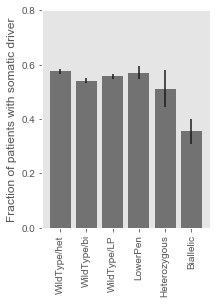

In [13]:
##plot figure 3B
f, ax = plt.subplots(figsize=(3, 4))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.set(style="ticks")

plot_data = somatic_oncogenic_by_gl.copy()
plot_data['group'] = plot_data['group'].str.split("_").str.get(0)
plot_data = plot_data.sort_values('group', ascending = False)
plot_data['error'] = plot_data['proportion_oncogenic'] - plot_data['lower']

ax.bar(plot_data['group'], plot_data['proportion_oncogenic'], 
                                     yerr=plot_data['error'], linewidth = 0,
                                     align='center', alpha=0.5, color = 'black')


ax.set_ylabel('Fraction of patients with somatic driver')
ax.set_xlabel('')
ax.set_ylim([0, 0.8])
plt.yticks(np.arange(0, 0.81, 0.2))
plt.xticks(rotation=90)
ax.xaxis.grid(False) 
ax.yaxis.grid(False) 


In [14]:
chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='Heterozygous')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Heterozygous')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Biallelic')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Biallelic')]['somatic_wt'].values[0]]], 
                                          correction=True) # het vs. biallelic
print p

chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='WildType/bi')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='WildType/bi')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Biallelic')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Biallelic')]['somatic_wt'].values[0]]],
                                          correction=True) #wt vs. biallelic 
print p

chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='LowerPen')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='LowerPen')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Biallelic')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Biallelic')]['somatic_wt'].values[0]]],
                                          correction=True) #lower pen vs. biallelic 
print p

chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='WildType/het')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='WildType/het')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Heterozygous')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Heterozygous')]['somatic_wt'].values[0]]],
                                          correction=True) #wt vs. het 
print p

chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='WildType/LP')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='WildType/LP')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='LowerPen')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='LowerPen')]['somatic_wt'].values[0]]],
                                          correction=True) #wt vs. biallelic 
print p


chi2, p, dof, ex = stats.chi2_contingency([[plot_data[(plot_data['group']=='WildType/LP')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='WildType/LP')]['somatic_wt'].values[0]], 
                                           [plot_data[(plot_data['group']=='LowerPen')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='LowerPen')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Heterozygous')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Heterozygous')]['somatic_wt'].values[0]],
                                           [plot_data[(plot_data['group']=='Biallelic')]['somatic_count'].values[0],
                                            plot_data[(plot_data['group']=='Biallelic')]['somatic_wt'].values[0]]], correction=True) #wt vs. het 
print p



0.0002495139265211005
1.9596764872075396e-07
1.422771322480635e-14
0.22600998178019868
0.46479727051107833
7.768980519731587e-14


In [15]:
#get number of somatic drivers
somatic_mutations = pd.read_csv("../data/all_somatic_drivers_3D.txt", sep = '\t')

In [16]:
#get number of somatic mutations corresponding to sampled groups above.
#remember to also include those patients for which no somatic mutations were detected
gl_wt_type_sampled = df_wildtype['Patient_ID'].unique().tolist()
#gl_LP_type_sampled = df_lower_pen['Patient_ID'].unique().tolist()

number_of_drivers_WT = somatic_mutations[somatic_mutations['Patient_ID'].isin(gl_wt_type_sampled)][['Tumor_Sample',
                                                                                                   'n_drivers']]
number_of_drivers_WT['allele_state'] = "WildType"
#print number_of_drivers_WT
pts_somatic_mutations =  somatic_mutations['Patient_ID'].unique().tolist()

patients_no_drivers = [i for i in gl_wt_type_sampled if i not in pts_somatic_mutations]
df_nodrivers = pd.DataFrame(patients_no_drivers, columns=['Tumor_Sample'])
df_nodrivers['n_drivers'] = 0
df_nodrivers['allele_state'] = "WildType"
number_of_drivers_WT = pd.concat([number_of_drivers_WT, df_nodrivers])


number_of_drivers_LP = somatic_mutations[somatic_mutations['Patient_ID'].isin(gl_lower_pen)][['Tumor_Sample',
                                                                                                   'n_drivers']]
number_of_drivers_LP['allele_state'] = "M/L/U"

pts_somatic_mutations =  somatic_mutations['Patient_ID'].unique().tolist()

patients_no_drivers = [i for i in gl_lower_pen if i not in pts_somatic_mutations]
df_nodrivers = pd.DataFrame(patients_no_drivers, columns=['Tumor_Sample'])
df_nodrivers['n_drivers'] = 0
df_nodrivers['allele_state'] = "M/L/U"
number_of_drivers_LP = pd.concat([number_of_drivers_LP, df_nodrivers])


number_of_drivers_het = somatic_mutations[somatic_mutations['Patient_ID'].isin(pts_hi_pen_het)][['Tumor_Sample',
                                                                                                   'n_drivers']]

number_of_drivers_het['allele_state'] = "Heterozygous"

patients_no_drivers = [i for i in pts_hi_pen_het if i not in pts_somatic_mutations]
df_nodrivers = pd.DataFrame(patients_no_drivers,columns=['Tumor_Sample'])
df_nodrivers['n_drivers'] = 0
df_nodrivers['allele_state'] = "Heterozygous"
number_of_drivers_het = pd.concat([number_of_drivers_het, df_nodrivers])


number_of_drivers_biallelic = somatic_mutations[somatic_mutations['Patient_ID'].isin(pts_hi_pen_biallelic)
                                               ][['Tumor_Sample', 'n_drivers']]

 
number_of_drivers_biallelic['allele_state'] = "Biallelic"

patients_no_drivers = [i for i in pts_hi_pen_biallelic if i not in pts_somatic_mutations]
df_nodrivers = pd.DataFrame(patients_no_drivers,columns=['Tumor_Sample'])
df_nodrivers['n_drivers'] = 0
df_nodrivers['allele_state'] = "Biallelic"
number_of_drivers_biallelic = pd.concat([number_of_drivers_biallelic, df_nodrivers])


number_of_drivers = pd.concat([number_of_drivers_WT, number_of_drivers_LP, number_of_drivers_het, 
                               number_of_drivers_biallelic])


number_of_drivers = number_of_drivers.fillna(0)


 anova
8.296651753721116e-07
   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1       group2    meandiff  lower  upper  reject
--------------------------------------------------------
 Biallelic   Heterozygous  0.633    0.1113 1.1546  True 
 Biallelic      M/L/U      0.6884   0.3459 1.031   True 
 Biallelic     WildType    0.6749   0.3617 0.988   True 
Heterozygous    M/L/U      0.0554  -0.3935 0.5043 False 
Heterozygous   WildType    0.0419  -0.3851 0.4688 False 
   M/L/U       WildType   -0.0136  -0.1793 0.1522 False 
--------------------------------------------------------


[Text(0,0,'WildType'),
 Text(0,0,'M/L/U'),
 Text(0,0,'Heterozygous'),
 Text(0,0,'Biallelic')]

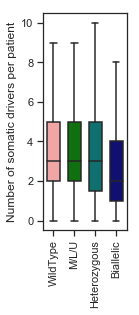

In [17]:
#number_of_drivers figure 3D
from scipy.stats import ttest_ind, ttest_ind_from_stats
list_WT = number_of_drivers[(number_of_drivers['allele_state']=='WildType')]['n_drivers'].tolist()
list_MLU = number_of_drivers[(number_of_drivers['allele_state']=='M/L/U')]['n_drivers'].tolist()
list_Biallelic = number_of_drivers[(number_of_drivers['allele_state']=='Biallelic')]['n_drivers'].tolist()
list_Het = number_of_drivers[(number_of_drivers['allele_state']=='Heterozygous')]['n_drivers'].tolist()

#compute p-values. The exact p-values will be different from what's reported due to the sampling differences 
#every run would provide a slightly different set of wildtype and lower penetrance patients
print "\n anova"
t, pval = stats.f_oneway(list_WT, list_Het,list_MLU, list_Biallelic) #anova
print pval

from statsmodels.stats.multicomp import pairwise_tukeyhsd
print pairwise_tukeyhsd(number_of_drivers['n_drivers'], number_of_drivers['allele_state'])

f, ax = plt.subplots(figsize=(1.5, 4))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.set(style="ticks")

                #label='big')inner="quartile", 
#ax = sns.catplot(x="allele_state", y="driver_count", kind="box", data=number_of_drivers);

ax = sns.boxplot(x="allele_state", y="n_drivers",data=number_of_drivers,showfliers = False,width = 0.6,
                 notch = False,
                palette={"WildType": "#fb9a99", "Heterozygous": 'teal', "Biallelic": "navy", 
                         "M/L/U": "green"
                        } )#inner="quartile", )
# ax = sns.stripplot(x="allele_state", y="driver_count",edgecolor='black',
#                   linewidth=1,
#                  data=number_of_drivers, dodge=True, jitter = True,)

ax.set_ylabel('Number of somatic drivers per patient')
ax.set_xlabel('')
#ax.set_ylim([0, 10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)





In [18]:
somatic_mutations_sub = somatic_oncogenic_status[somatic_oncogenic_status['n_drivers']>0]

somatic_mutations_sub['allele_state'] = np.where(somatic_mutations_sub['Patient_ID'].isin(pts_hi_pen_biallelic), 'Biallelic',
                                               'WildType-Het')# somatic_mutations_sub['allele_state']) #)

clinical_data_sub = clinical_data[['Patient_ID', 'Proposed_level']]

clinical_data_sub['allele_state'] = np.where(clinical_data_sub['Patient_ID'].isin(pts_hi_pen_biallelic), 'Biallelic',
                                               'WildType-Het' ) #clinical_data_sub['allele_state'] )


tumorcount = pd.DataFrame({
        'tumorcount' : 
        clinical_data_sub.groupby(['Proposed_level','allele_state'])['Patient_ID'].nunique()#.groupby(['Proposed_level']).median()
    }).reset_index()
rate_drivers = pd.DataFrame({
        'driver_count' : 
        somatic_mutations_sub[somatic_mutations_sub['n_drivers']>0].groupby(['Proposed_level','allele_state'])['Patient_ID'].nunique()#.groupby(['Proposed_level']).median()
    }).reset_index()
rate_drivers = pd.merge(rate_drivers, tumorcount, on = ['Proposed_level', 'allele_state'], 
                        how = 'left')


[Text(0,0,'Invasive Breast Carcinoma'),
 Text(0,0,'Gastrointestinal Stromal Tumor'),
 Text(0,0,'Ovarian Cancer'),
 Text(0,0,'Non-Small Cell Lung Cancer'),
 Text(0,0,'Endometrial Carcinoma'),
 Text(0,0,'Diffuse Glioma'),
 Text(0,0,'Prostate Cancer'),
 Text(0,0,'Esophagogastric Cancer'),
 Text(0,0,'Bone Cancer'),
 Text(0,0,'Cholangiocarcinoma'),
 Text(0,0,'Colorectal Adenocarcinoma'),
 Text(0,0,'Pancreatic Adenocarcinoma')]

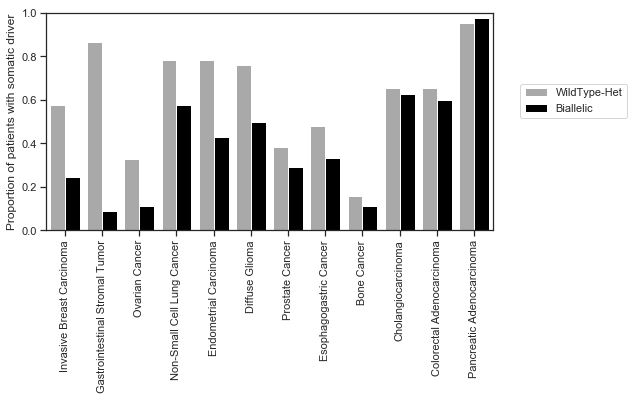

In [19]:
#figure 3C
rate_drivers['somatic_no_driver'] = rate_drivers['tumorcount'] - rate_drivers['driver_count']
rate_drivers['proportion'] = rate_drivers['driver_count']/rate_drivers['tumorcount']
rate_drivers['Proposed_level'] = rate_drivers['Proposed_level'].str.replace("_", " ")


plot_tumors = rate_drivers[(rate_drivers['allele_state']=='Biallelic') &
                           (rate_drivers['tumorcount']>=5)]['Proposed_level'].unique().tolist()
rate_drivers_plot = rate_drivers[rate_drivers['Proposed_level'].isin(plot_tumors)]
rate_drivers_plot = rate_drivers_plot[~(rate_drivers_plot['Proposed_level']=='EXCLUDE')]
f, ax = plt.subplots(figsize=(8, 4))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.set(style="ticks")

order_tumortypes =[ 'Gastrointestinal Stromal Tumor', 'Invasive Breast Carcinoma',
                   'Ovarian Cancer', 
                   'Non-Small Cell Lung Cancer','Endometrial Carcinoma','Cholangiocarcinoma', 
                   'Prostate Cancer', 'Esophagogastric Cancer', 
                   'Diffuse Glioma',  'Bone Cancer','Colorectal Adenocarcinoma', 'Pancreatic Adenocarcinoma',]
order_tumortypes = ['Invasive Breast Carcinoma', 'Gastrointestinal Stromal Tumor', 'Ovarian Cancer', 'Non-Small Cell Lung Cancer', 'Endometrial Carcinoma', 'Diffuse Glioma', 'Prostate Cancer', 'Esophagogastric Cancer', 'Bone Cancer', 'Cholangiocarcinoma', 'Colorectal Adenocarcinoma', 'Pancreatic Adenocarcinoma']
                   
order_tumortypes = [i for i in order_tumortypes if i not in ['Other', 'Nerve Sheath Tumor', 'Cancer of Unknown Primary']]

dict_tumor_index = {k: v for v, k in enumerate(order_tumortypes)}


rate_drivers_plot['order'] = rate_drivers_plot['Proposed_level'].map(dict_tumor_index)
rate_drivers_plot = rate_drivers_plot[rate_drivers_plot['Proposed_level'].isin(order_tumortypes)]
rate_drivers_plot = rate_drivers_plot.sort_values('order')
ax = sns.barplot(x="Proposed_level", y="proportion",data=rate_drivers_plot,
                 hue = 'allele_state', 
                 palette={"WildType-Het": "darkgrey",#"#0a69ad", 
                           "Biallelic": "black"},# "#80cdbb"},
                hue_order = ['WildType-Het','Biallelic'])

ax.set_ylabel('Proportion of patients with somatic driver')
ax.set_xlabel('')
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.7),
           fancybox=True, shadow=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [20]:
import scipy
import scipy.stats as stats

rate_drivers_plot = rate_drivers_plot.fillna(0)
rate_drivers_plot = rate_drivers_plot.pivot_table(index = 'Proposed_level', columns = ['allele_state'], 
                                       values = ['driver_count', 'somatic_no_driver'])

rate_drivers_plot = rate_drivers_plot.fillna(0)
rate_drivers_plot.columns = ['drivers_biallelic',  'drivers_wt', "nodriver_biallelic",
                       'nodriver_wt']

rate_drivers_plot['fishers_pvalue_WT_vs_Biallelic'] =  rate_drivers_plot.apply(
        lambda r: scipy.stats.fisher_exact([[r.drivers_wt, r.nodriver_wt ],
                                            [r.drivers_biallelic, r.nodriver_biallelic]])[1],#alternative= 'greater')[1],
        axis=1)
rate_drivers_plot['odds_ratio'] =  rate_drivers_plot.apply(
        lambda r: scipy.stats.fisher_exact([[r.drivers_wt, r.nodriver_wt ],
                                            [r.drivers_biallelic, r.nodriver_biallelic]])[0],#alternative= 'greater')[1],
        axis=1)
adj_pval_all = statsmodels.sandbox.stats.multicomp.multipletests(rate_drivers_plot['fishers_pvalue_WT_vs_Biallelic'], 
                                                                 alpha=0.05, method='bonferroni', is_sorted=False)
rate_drivers_plot['FishersExact_BH_WTvsBi']  = np.array(adj_pval_all[1])


rate_drivers_plot = rate_drivers_plot.sort_values('fishers_pvalue_WT_vs_Biallelic')
rate_drivers_plot = rate_drivers_plot.reset_index()
order_tumortypes = rate_drivers_plot['Proposed_level'].tolist()
rate_drivers_plot[(rate_drivers_plot['FishersExact_BH_WTvsBi']<0.05) ]

,Proposed_level,drivers_biallelic,drivers_wt,nodriver_biallelic,nodriver_wt,fishers_pvalue_WT_vs_Biallelic,odds_ratio,FishersExact_BH_WTvsBi
0,Invasive Breast Carcinoma,26,1149,81,845,1.077013e-11,4.236186,1.292416e-10
1,Gastrointestinal Stromal Tumor,1,156,10,24,9.053016e-08,65.000000,1.086362e-06
